In [5]:
import pandas as pd
import numpy as np
df = pd.read_parquet("C:/Users/james/OneDrive/Documents/GitHub/solana-qrf-interval-forecasting/data/solana_master_raw.parquet")  # your master panel

def clean_ohlcv_panel(df, ohlcv_cols=None, max_ffill_steps=2, drop_tokens=None):
    """
    Clean OHLCV panel for modeling:
    - Drop tokens with excessive missingness or known issues.
    - Clip each token's history to start at first valid OHLCV observation.
    - Forward-fill short OHLCV gaps (≤ max_ffill_steps).
    - Drop rows with longer OHLCV gaps.
    - Add a `was_imputed` flag to track filled rows.

    Parameters:
    ----------
    df : pd.DataFrame
        Input DataFrame with ['timestamp', 'token'] and OHLCV columns.
    ohlcv_cols : list or None
        List of OHLCV columns. If None, defaults to standard OHLCV.
    max_ffill_steps : int
        Maximum number of consecutive NaNs to fill per OHLCV column.
    drop_tokens : list or None
        Tokens to exclude entirely (e.g. those with no viable history).

    Returns:
    -------
    pd.DataFrame
        Cleaned and trimmed DataFrame with `was_imputed` and `post_ohlcv_launch` flags.
    """
    if ohlcv_cols is None:
        ohlcv_cols = ['open_usd', 'high_usd', 'low_usd', 'close_usd', 'volume_usd']

    df = df.copy()

    # Drop known bad tokens
    if drop_tokens:
        df = df[~df['token'].isin(drop_tokens)]

    # Identify rows where any OHLCV is missing
    df['ohlcv_missing'] = df[ohlcv_cols].isnull().any(axis=1)

    # Get the first valid timestamp for each token based on OHLCV presence
    token_start = df[~df['ohlcv_missing']].groupby('token')['timestamp'].min().to_dict()

    # Add flag: True if row is after first valid OHLCV for its token
    df['post_ohlcv_launch'] = df.apply(
        lambda row: row['timestamp'] >= token_start.get(row['token'], pd.Timestamp.max),
        axis=1
    )

    # Keep only post-launch rows
    df = df[df['post_ohlcv_launch']].copy()

    # Sort by token and timestamp before filling
    df = df.sort_values(['token', 'timestamp'])

    # Forward-fill short gaps (≤ max_ffill_steps)
    for col in ohlcv_cols:
        df[col] = df.groupby('token')[col].transform(lambda x: x.ffill(limit=max_ffill_steps))

    # Flag rows where forward-fill still left missing values
    df['was_imputed'] = df[ohlcv_cols].isnull().any(axis=1)

    # Drop rows where longer OHLCV gaps couldn't be filled
    df = df[~df['was_imputed']].copy()

    return df


In [9]:
df_cleaned = clean_ohlcv_panel(df, drop_tokens=["$COLLAT", "titcoin"])

# Optional: inspect
print(df_cleaned.shape)
print("Was imputed:", df_cleaned['was_imputed'].sum())

(6464, 32)
Was imputed: 0


# Audit: Cleaning Impact

In [11]:
# 1. Check % of rows removed
raw_rows = len(df)
cleaned_rows = len(df_cleaned)
drop_pct = 100 * (raw_rows - cleaned_rows) / raw_rows

print(f"Original rows: {raw_rows}")
print(f"Remaining rows after cleaning: {cleaned_rows}")
print(f"Percentage of rows dropped: {drop_pct:.2f}%")


Original rows: 8326
Remaining rows after cleaning: 6464
Percentage of rows dropped: 22.36%


In [13]:

# 2. Check per-column missingness (before vs after)
cols_to_check = ['open_usd', 'high_usd', 'low_usd', 'close_usd', 'volume_usd']

# Before cleaning
pre_missing = df[cols_to_check].isnull().mean().rename("pre_missing")

# After cleaning
post_missing = df_cleaned[cols_to_check].isnull().mean().rename("post_missing")

# Combine
missing_impact = pd.concat([pre_missing, post_missing], axis=1)
missing_impact['improvement_%'] = 100 * (missing_impact['pre_missing'] - missing_impact['post_missing'])

print(missing_impact)


            pre_missing  post_missing  improvement_%
open_usd       0.183041           0.0      18.304108
high_usd       0.183041           0.0      18.304108
low_usd        0.183041           0.0      18.304108
close_usd      0.183041           0.0      18.304108
volume_usd     0.126351           0.0      12.635119


In [15]:
# 3. Count how many tokens were removed
removed_tokens = set(df['token'].unique()) - set(df_cleaned['token'].unique())
print("Tokens removed:", removed_tokens)
print("Count:", len(removed_tokens))


Tokens removed: {'titcoin', '$COLLAT'}
Count: 2


In [17]:
# 4. Distribution of dropped rows per token
token_row_diff = df['token'].value_counts() - df_cleaned['token'].value_counts()
token_row_diff = token_row_diff.dropna().astype(int).sort_values(ascending=False)
print(token_row_diff.head())


token
LAUNCHCOIN    100
UFD            88
MEW            61
SIGMA          61
Ray            61
Name: count, dtype: int32


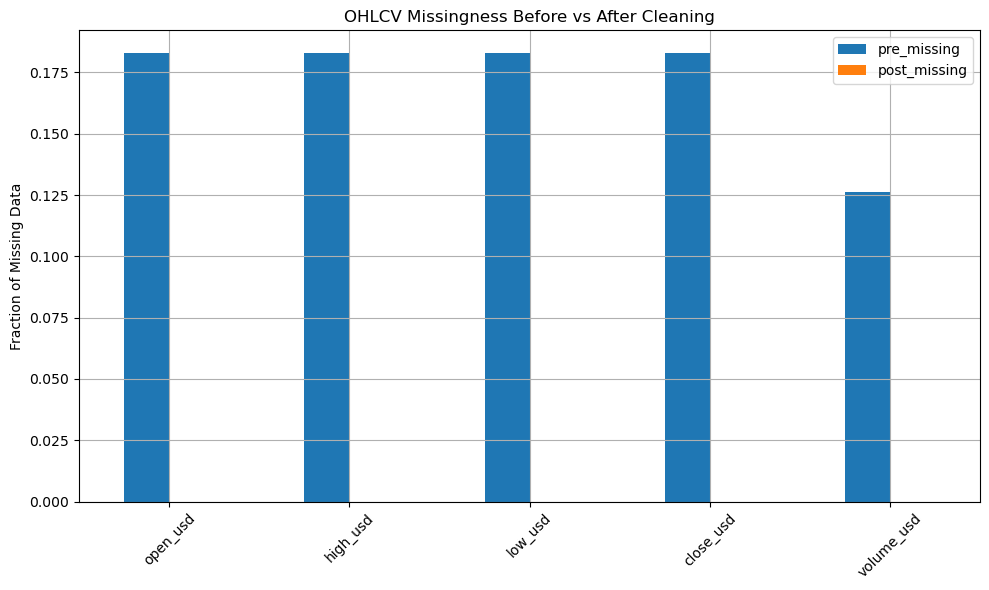

Original rows: 8326
Rows after cleaning: 6464
Dropped rows: 1862 (22.36%)
Tokens removed: {'titcoin', '$COLLAT'}


In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Columns to track
ohlcv_cols = ['open_usd', 'high_usd', 'low_usd', 'close_usd', 'volume_usd']

# Step 1: Compare missingness before vs after
pre_missing = df[ohlcv_cols].isnull().mean().rename("pre_missing")
post_missing = df_cleaned[ohlcv_cols].isnull().mean().rename("post_missing")

missing_impact = pd.concat([pre_missing, post_missing], axis=1)
missing_impact['improvement_%'] = 100 * (missing_impact['pre_missing'] - missing_impact['post_missing'])

# Step 2: Visualize
missing_impact[['pre_missing', 'post_missing']].plot(kind='bar', figsize=(10, 6))
plt.title("OHLCV Missingness Before vs After Cleaning")
plt.ylabel("Fraction of Missing Data")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 3: Summary statistics
raw_rows = len(df)
cleaned_rows = len(df_cleaned)
drop_pct = 100 * (raw_rows - cleaned_rows) / raw_rows

removed_tokens = set(df['token'].unique()) - set(df_cleaned['token'].unique())

print(f"Original rows: {raw_rows}")
print(f"Rows after cleaning: {cleaned_rows}")
print(f"Dropped rows: {raw_rows - cleaned_rows} ({drop_pct:.2f}%)")
print(f"Tokens removed: {removed_tokens}")


In [22]:
# Confirm no missing OHLCV data
assert df_cleaned[ohlcv_cols].isnull().sum().sum() == 0, "Missing OHLCV data remains!"

# Confirm expected columns exist
assert 'post_ohlcv_launch' in df_cleaned.columns
assert 'was_imputed' in df_cleaned.columns

# Check token coverage
print(df_cleaned['token'].value_counts())

# Optional: look at timestamp continuity for a sample token
token = df_cleaned['token'].unique()[0]
print(df_cleaned[df_cleaned['token'] == token]['timestamp'].diff().value_counts())


token
Fartcoin      361
RETARDIO      361
BOME          361
$WIF          304
PONKE         304
GOAT          304
ZEREBRO       304
FWOG          304
AVA           304
ALCH          304
GIGA          303
MOODENG       303
POPCAT        303
Pnut          303
$michi        301
MLG           301
Ray           301
SIGMA         301
MEW           301
UFD           274
LAUNCHCOIN    262
Name: count, dtype: int64
timestamp
0 days 12:00:00     302
29 days 00:00:00      1
Name: count, dtype: int64


In [24]:
df_cleaned.to_parquet("solana_cleaned_ohlcv.parquet", index=False)

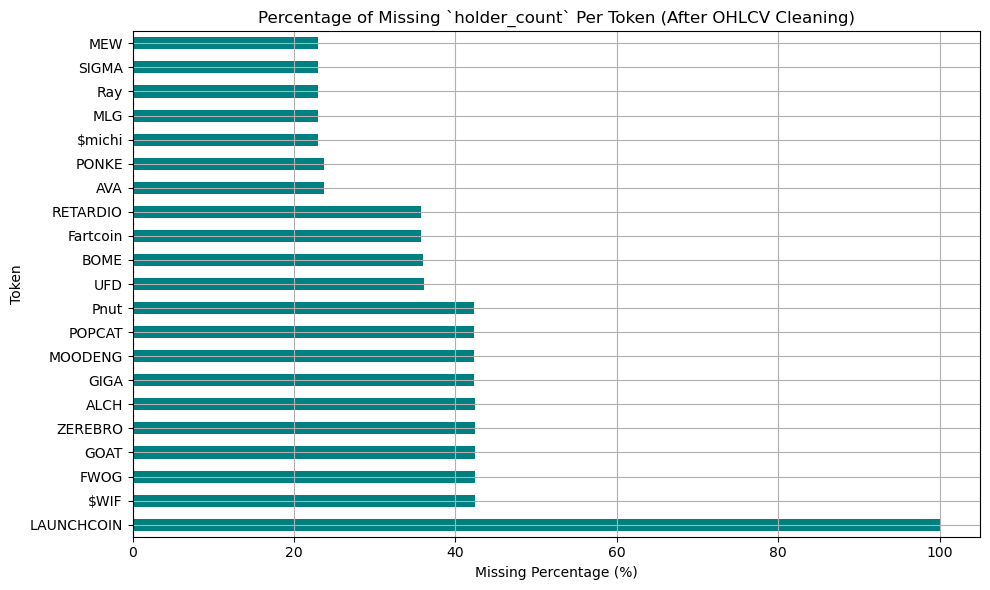

In [28]:
# Checking holder_count

# Check percentage of missing holder_count per token
holder_missing_summary = df_cleaned.groupby('token')['holder_count'].apply(lambda x: x.isnull().mean() * 100)
holder_missing_summary = holder_missing_summary.sort_values(ascending=False)

# Display it cleanly
import matplotlib.pyplot as plt

holder_missing_summary.plot(kind='barh', figsize=(10, 6), color='teal')
plt.title("Percentage of Missing `holder_count` Per Token (After OHLCV Cleaning)")
plt.xlabel("Missing Percentage (%)")
plt.ylabel("Token")
plt.grid(True)
plt.tight_layout()
plt.show()
